In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from IPython.display import display, Math, Latex

In [3]:
display(Math(r'regret = R_{opt} - R_{strategy}'))

<IPython.core.display.Math object>

In [4]:
class Strategy:

    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = np.zeros(n_arms)
        self.arms_actions = np.zeros(n_arms)


    def flush(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)


    def update_reward(self, arm: int, reward: int):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1


    def choose_arm(self):
        raise NotImplementedError

In [5]:
class EpsGreedy(Strategy):

    def __init__(self, n_arms: int, eps: float = .1):
        super().__init__(n_arms)
        self.eps = eps

    def choose_arm(self):

        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1)
        else:
            return np.argmax(self.arms_states / self.arms_actions)

In [7]:
display(Math(r'arm = arg\underset{j}max(\overline{x_j} + \sqrt{\frac{2\ln{n}}{n_j}})'))

<IPython.core.display.Math object>

In [8]:
# Class Upper Confidence Bound (UCB)

class UCB1(Strategy):

    def choose_arm(self):
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            return np.argmax(self.ucb())

    def ucb(self):
        ucb = self.arms_states / self.arms_actions
        ucb += np.sqrt(2 * np.log(self.n_iters) / self.arms_actions)
        return ucb


In [9]:
class Thompsen(Strategy):

    def __init__(self, n_arms: int):
        pass

    def update_rewards(self, arm: int, reward: int):
        pass

    def choose_arm(self):
        return arm

In [10]:
class BernoulliEnv:
    

    def __init__(self, arms_proba: list):
        self.arms_proba = arms_proba


    @property
    def n_arms(self):
        return len(self.arms_proba)

    
    def pull_arm(self, arm_id: int):
        if random.random() < self.arms_proba[arm_id]:
            return 1
        else:
            return 0

In [11]:
class Bandit:
    

    def __init__(self, env: BernoulliEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy


    def action(self):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm)
        self.strategy.update_reward(arm, reward)

In [15]:
def calculate_regret(env: BernoulliEnv, strategy: Strategy, n_iters=2000):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    for i in range(n_iters):
        reward = bandit.strategy.arms_actions.dot(env.arms_proba)
        optimal_reward = np.max(env.arms_proba) * i
        regret = optimal_reward - reward
        regrets.append(regret)
        bandit.action()
    return regrets

In [16]:
be = BernoulliEnv([.3, .5, .7])
eps_1 = EpsGreedy(be.n_arms, .1)
eps_2 = EpsGreedy(be.n_arms, .3)
eps_3 = EpsGreedy(be.n_arms, .5)
ucb = UCB1(be.n_arms)

In [18]:
# Calculate regrets
eps_regrets = calculate_regret(be, eps_1)
eps_2_regrets = calculate_regret(be, eps_2)
eps_3_regrets = calculate_regret(be, eps_3)
ucb_regrets = calculate_regret(be, ucb)

/var/folders/wt/fs62y8p10lxgyr__1q15y4_m0000gn/T/ipykernel_1857/664325328.py:12: RuntimeWarning: invalid value encountered in divide
  return np.argmax(self.arms_states / self.arms_actions)


Text(0, 0.5, 'cumulative regret (less is better)')

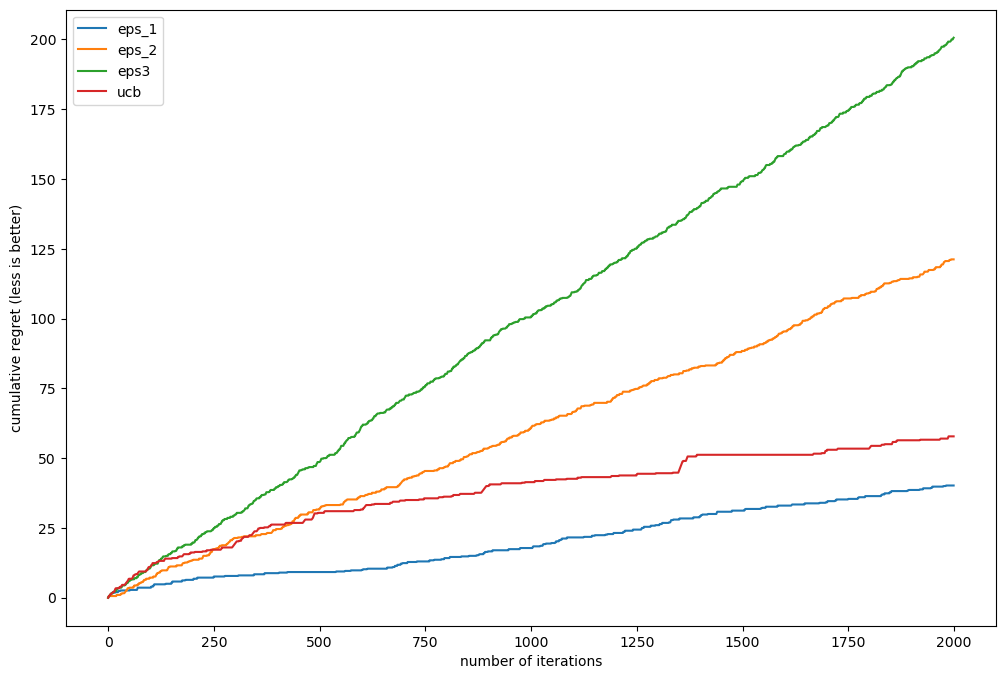

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(eps_regrets, label='eps_1')
plt.plot(eps_2_regrets, label='eps_2')
plt.plot(eps_3_regrets, label='eps3')
plt.plot(ucb_regrets, label='ucb')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('cumulative regret (less is better)')